In [11]:
#📒 Notebook 04 — Margin Optimization (costos fijos por dept)
#🎯 Objetivo

#Usar las elasticidades estimadas (pooled) para:

#simular cambios de precio

#estimar impacto en unidades, revenue y profit

#identificar el precio que maximiza margen por segmento

In [5]:
# 1) Setup + carga de datos

#Usamos df_pool (ya agregado por dept–country–week).

import pandas as pd
import numpy as np


In [6]:
#0.1 Setup + carga de inputs

#Usa el dataset filtrado que ya generaste (df_filt) o el archivo guardado del Notebook 03.

df_filt = pd.read_parquet("elasticity_input.parquet")


In [7]:
#Check

print("df_filt shape:", df_filt.shape)
print(df_filt[['item_id','store_id','country','wm_yr_wk','units_sold','sell_price','dept_id']].isna().sum())
df_filt.head()


df_filt shape: (91034, 14)
item_id       0
store_id      0
country       0
wm_yr_wk      0
units_sold    0
sell_price    0
dept_id       0
dtype: int64


,id,item_id,dept_id,store_id,state_id,cat_id,d,units_sold,date,wm_yr_wk,sell_price,country,revenue,series_key
0,HOBBIES_1_310_CA_1_validation,HOBBIES_1_310,HOBBIES_1,CA_1,CA,HOBBIES,d_1549,1,2015-04-26,11513,4.98,US,4.98,HOBBIES_1_310_CA_1_US
1,HOBBIES_1_358_CA_1_validation,HOBBIES_1_358,HOBBIES_1,CA_1,CA,HOBBIES,d_1549,3,2015-04-26,11513,2.63,US,7.89,HOBBIES_1_358_CA_1_US
2,FOODS_3_012_CA_1_validation,FOODS_3_012,FOODS_3,CA_1,CA,FOODS,d_1549,4,2015-04-26,11513,2.28,US,9.12,FOODS_3_012_CA_1_US
3,FOODS_3_057_CA_1_validation,FOODS_3_057,FOODS_3,CA_1,CA,FOODS,d_1549,1,2015-04-26,11513,2.88,US,2.88,FOODS_3_057_CA_1_US
4,FOODS_3_081_CA_1_validation,FOODS_3_081,FOODS_3,CA_1,CA,FOODS,d_1549,1,2015-04-26,11513,4.42,US,4.42,FOODS_3_081_CA_1_US


In [8]:
#0.2 Agregación semanal: df_weekly

#⚠️ Usamos el patrón estable: groupby(..., observed=True) + reset_index()

df_weekly = (
    df_filt
    .groupby(['item_id','store_id','country','wm_yr_wk'], observed=True)
    .agg(
        units_sold=('units_sold','sum'),
        sell_price=('sell_price','mean')
    )
    .reset_index()
)

print("df_weekly shape:", df_weekly.shape)
df_weekly.head()

df_weekly shape: (22587, 6)


,item_id,store_id,country,wm_yr_wk,units_sold,sell_price
0,FOODS_3_002,CA_3,US,11513,12,2.5
1,FOODS_3_002,CA_3,US,11517,4,1.5
2,FOODS_3_002,CA_3,US,11518,22,2.5
3,FOODS_3_002,CA_3,US,11519,20,2.5
4,FOODS_3_002,CA_3,US,11520,19,2.5


In [9]:
item_dept_map = df_filt[['item_id','dept_id']].drop_duplicates()
df_weekly = df_weekly.merge(item_dept_map, on='item_id', how='left')

print("Null dept_id in df_weekly:", df_weekly['dept_id'].isna().sum())


Null dept_id in df_weekly: 0


In [12]:
#Logs + series_key para filtros semanales

df_weekly = df_weekly[(df_weekly['units_sold'] > 0) & (df_weekly['sell_price'] > 0)].copy()

df_weekly['log_units'] = np.log(df_weekly['units_sold'])
df_weekly['log_price'] = np.log(df_weekly['sell_price'])

df_weekly['series_key'] = (
    df_weekly['item_id'].astype(str) + "_" +
    df_weekly['store_id'].astype(str) + "_" +
    df_weekly['country'].astype(str)
)


In [13]:
#Filtros de calidad semanales: contruir df_w

MIN_WEEKS = 26
MIN_UNIQUE_PRICES_W = 3

wk_stats = (
    df_weekly
    .groupby('series_key', observed=True)
    .agg(
        obs=('log_units','size'),
        unique_prices=('sell_price','nunique')
    )
    .reset_index()
)

good_keys = wk_stats[
    (wk_stats['obs'] >= MIN_WEEKS) &
    (wk_stats['unique_prices'] >= MIN_UNIQUE_PRICES_W)
]['series_key']

df_w = df_weekly[df_weekly['series_key'].isin(good_keys)].copy()

print("Weekly series before:", wk_stats.shape[0])
print("Weekly series after:", df_w['series_key'].nunique())
print("Weekly rows after:", df_w.shape[0])
print(df_w.columns)


Weekly series before: 513
Weekly series after: 499
Weekly rows after: 22167
Index(['item_id', 'store_id', 'country', 'wm_yr_wk', 'units_sold',
       'sell_price', 'dept_id', 'log_units', 'log_price', 'series_key'],
      dtype='object')


In [14]:
#Dataset pooled: construir df_pool

df_pool = (
    df_w
    .groupby(['dept_id','country','wm_yr_wk'], observed=True)
    .agg(
        units_sold=('units_sold','sum'),
        sell_price=('sell_price','mean')
    )
    .reset_index()
)

df_pool = df_pool[(df_pool['units_sold'] > 0) & (df_pool['sell_price'] > 0)].copy()
df_pool['log_units'] = np.log(df_pool['units_sold'])
df_pool['log_price'] = np.log(df_pool['sell_price'])

df_pool = df_pool.sort_values(['dept_id','country','wm_yr_wk'])
df_pool['t'] = df_pool.groupby(['dept_id','country'], observed=True).cumcount()

print("df_pool shape:", df_pool.shape)
df_pool.head()


df_pool shape: (318, 8)


,dept_id,country,wm_yr_wk,units_sold,sell_price,log_units,log_price,t
0,FOODS_3,US,11513,4272,3.277018,8.359838,1.186934,0
1,FOODS_3,US,11514,5289,3.229075,8.573384,1.172196,1
2,FOODS_3,US,11515,3998,3.122432,8.293550,1.138612,2
3,FOODS_3,US,11516,1961,3.349706,7.581210,1.208873,3
4,FOODS_3,US,11517,2225,3.304478,7.707512,1.195278,4


In [15]:
#1️⃣ Definir costos fijos por categoría (supuesto de negocio)

#Supuesto: el costo unitario es constante dentro de cada categoría

costs_by_dept = {
    'FOODS_3': 1.80,
    'HOBBIES_1': 6.50
}

df_pool['unit_cost'] = df_pool['dept_id'].map(costs_by_dept)

df_pool[['dept_id','unit_cost']].drop_duplicates()


,dept_id,unit_cost
0,FOODS_3,1.8
159,HOBBIES_1,6.5


In [16]:
df_pool[['units_sold','sell_price','unit_cost']].dtypes


units_sold       int16
sell_price     float64
unit_cost     category
dtype: object

In [17]:
df_pool['units_sold'] = pd.to_numeric(df_pool['units_sold'], errors='coerce')
df_pool['sell_price'] = pd.to_numeric(df_pool['sell_price'], errors='coerce')
df_pool['unit_cost'] = pd.to_numeric(df_pool['unit_cost'], errors='coerce')

print(df_pool[['units_sold','sell_price','unit_cost']].dtypes)
print("Nulls:\n", df_pool[['units_sold','sell_price','unit_cost']].isna().sum())


units_sold      int16
sell_price    float64
unit_cost     float64
dtype: object
Nulls:
 units_sold    0
sell_price    0
unit_cost     0
dtype: int64


In [18]:
df_pool['dept_id'] = df_pool['dept_id'].astype(str).str.strip()


In [19]:
df_pool['unit_cost'] = df_pool['dept_id'].map(costs_by_dept)


In [20]:
df_pool[['dept_id','unit_cost']].drop_duplicates().head(10)
print("Null unit_cost:", df_pool['unit_cost'].isna().sum())


Null unit_cost: 0


In [21]:
df_pool['revenue'] = df_pool['units_sold'] * df_pool['sell_price']
df_pool['cost'] = df_pool['units_sold'] * df_pool['unit_cost']
df_pool['profit'] = df_pool['revenue'] - df_pool['cost']


In [22]:
#Construir baseline

baseline = (
    df_pool
    .groupby(['dept_id','country'], as_index=False)
    .agg(
        avg_price=('sell_price','mean'),
        units=('units_sold','sum'),
        revenue=('revenue','sum'),
        profit=('profit','sum'),
        unit_cost=('unit_cost','first')
    )
)

baseline


/tmp/ipykernel_132/2208579287.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['dept_id','country'], as_index=False)


,dept_id,country,avg_price,units,revenue,profit,unit_cost
0,FOODS_3,US,3.376597,234969,789041.032990,366096.832990,1.8
1,FOODS_3,MX,3.080561,79052,241894.880591,99601.280591,1.8
2,FOODS_3,ES,3.364618,42925,143766.339095,66501.339095,1.8
3,HOBBIES_1,US,5.137347,8506,43818.810321,-11470.189679,6.5
4,HOBBIES_1,MX,3.460509,6102,21127.450249,-18535.549751,6.5
5,HOBBIES_1,ES,3.825178,4900,18746.652905,-13103.347095,6.5


In [23]:
import statsmodels.api as sm

results = []

for (dept, ctry), g in df_pool.groupby(['dept_id','country'], observed=True):
    X = sm.add_constant(g[['log_price','t']])
    y = g['log_units']
    res = sm.OLS(y, X).fit(cov_type='HC3')

    results.append({
        'dept_id': dept,
        'country': ctry,
        'elasticity': res.params['log_price'],
        'p_value': res.pvalues['log_price'],
        'r2': res.rsquared,
        'n_obs': int(res.nobs)
    })

seg_elast = pd.DataFrame(results)

seg_elast



,dept_id,country,elasticity,p_value,r2,n_obs
0,FOODS_3,US,-8.502019,0.000003,0.396799,53
1,FOODS_3,MX,-0.365523,0.648037,0.422731,53
2,FOODS_3,ES,0.465318,0.611651,0.163545,53
3,HOBBIES_1,US,1.522437,0.191251,0.166479,53
4,HOBBIES_1,MX,0.198218,0.598700,0.003047,53
5,HOBBIES_1,ES,-0.194975,0.753850,0.049334,53


In [24]:
#Simulación de escenarios de precio (profit maximization)

elasticities = seg_elast[['dept_id','country','elasticity']]
baseline = baseline.merge(elasticities, on=['dept_id','country'], how='left')
baseline


,dept_id,country,avg_price,units,revenue,profit,unit_cost,elasticity
0,FOODS_3,US,3.376597,234969,789041.032990,366096.832990,1.8,-8.502019
1,FOODS_3,MX,3.080561,79052,241894.880591,99601.280591,1.8,-0.365523
2,FOODS_3,ES,3.364618,42925,143766.339095,66501.339095,1.8,0.465318
3,HOBBIES_1,US,5.137347,8506,43818.810321,-11470.189679,6.5,1.522437
4,HOBBIES_1,MX,3.460509,6102,21127.450249,-18535.549751,6.5,0.198218
5,HOBBIES_1,ES,3.825178,4900,18746.652905,-13103.347095,6.5,-0.194975


In [25]:
#Simulación de escenarios de precio
#Definimos cambios de precio:

price_changes = [-0.10, -0.05, 0.0, 0.05, 0.10]


In [26]:
#Creamos simulaciones

sim_results = []

for _, row in baseline.iterrows():
    for pc in price_changes:
        new_price = row['avg_price'] * (1 + pc)
        
        # Demanda ajustada por elasticidad
        new_units = row['units'] * (new_price / row['avg_price']) ** row['elasticity']
        
        revenue = new_units * new_price
        cost = new_units * costs_by_dept[row['dept_id']]
        profit = revenue - cost
        
        sim_results.append({
            'dept_id': row['dept_id'],
            'country': row['country'],
            'price_change_pct': pc,
            'new_price': new_price,
            'units': new_units,
            'revenue': revenue,
            'profit': profit
        })

sim_df = pd.DataFrame(sim_results)


In [27]:
#Ccomparación vs baseline: Unimos baseline para medir impacto

sim_df = sim_df.merge(
    baseline[['dept_id','country','profit']],
    on=['dept_id','country'],
    suffixes=('','_baseline')
)

sim_df['profit_delta'] = sim_df['profit'] - sim_df['profit_baseline']


In [28]:
#Precio óptimo por segmento: identificamos el escenario con mayor profit:

optimal_pricing = (
    sim_df
    .sort_values('profit', ascending=False)
    .groupby(['dept_id','country'])
    .first()
    .reset_index()
)

optimal_pricing


,dept_id,country,price_change_pct,new_price,units,revenue,profit,profit_baseline,profit_delta
0,FOODS_3,ES,0.1,3.701080,44871.549629,1.660732e+05,85304.405512,66501.339095,18803.066417
1,FOODS_3,MX,0.1,3.388618,76345.401949,2.587054e+05,121283.652271,99601.280591,21682.371680
2,FOODS_3,US,-0.1,3.038937,575495.089299,1.748894e+06,713002.403973,366096.832990,346905.570983
3,HOBBIES_1,ES,0.1,4.207696,4809.783616,2.023811e+04,-11025.485968,-13103.347095,2077.861127
4,HOBBIES_1,MX,0.1,3.806560,6218.375840,2.367062e+04,-16748.822318,-18535.549751,1786.727432
5,HOBBIES_1,US,0.1,5.651081,9834.293170,5.557439e+04,-8348.515731,-11470.189679,3121.673947


In [ ]:
#1️⃣ Interpretación clara del output (qué nos dice el modelo)

#Analizamos por segmento:
| País   | Cambio óptimo   | Lectura                                                                             |
| ------ | --------------- | ----------------------------------------------------------------------------------- |
| **US** | **−10% precio** | Mercado **altamente elástico** → bajar precio aumenta volumen y **maximiza profit** |
| MX     | +10% precio     | Demanda poco sensible → subir precio mejora margen                                  |
| ES     | +10% precio     | Demanda poco sensible → conviene capturar margen                                    |


| País | Cambio óptimo | Lectura                                          |
| ---- | ------------- | ------------------------------------------------ |
| US   | +10% precio   | Baja sensibilidad → subir precio reduce pérdidas |
| MX   | +10% precio   | Igual                                            |
| ES   | +10% precio   | Igual                                            |

#La optimización de precios muestra que, incluso con elasticidades estimadas, no todos los problemas de rentabilidad se resuelven vía pricing. Mientras que FOODS presenta oportunidades claras de optimización 
#diferenciada por mercado, HOBBIES evidencia un problema estructural de costos o demanda que requiere decisiones más profundas que ajustes de precio.

In [ ]:
#📊 Curvas Precio vs Profit por segmento

#La idea es visualizar el precio optimo.

#🎯 Qué vamos a mostrar

#Para cada combinación dept × país:

#eje X → precio

#eje Y → profit

#punto destacado → precio óptimo

In [30]:
import matplotlib.pyplot as plt

In [31]:
print(sim_df.columns)
sim_df.head()


Index(['dept_id', 'country', 'price_change_pct', 'new_price', 'units',
       'revenue', 'profit', 'profit_baseline', 'profit_delta'],
      dtype='object')


,dept_id,country,price_change_pct,new_price,units,revenue,profit,profit_baseline,profit_delta
0,FOODS_3,US,-0.10,3.038937,575495.089299,1.748894e+06,713002.403973,366096.83299,346905.570983
1,FOODS_3,US,-0.05,3.207767,363416.715839,1.165756e+06,511606.162227,366096.83299,145509.329237
2,FOODS_3,US,0.00,3.376597,234969.000000,7.933957e+05,370451.453099,366096.83299,4354.620109
3,FOODS_3,US,0.05,3.545427,155188.217761,5.502085e+05,270869.704696,366096.83299,-95227.128294
4,FOODS_3,US,0.10,3.714257,104493.475302,3.881156e+05,200027.351154,366096.83299,-166069.481836


In [32]:
def plot_price_profit(sim_df, optimal_pricing, dept, country):
    data = sim_df[
        (sim_df['dept_id'] == dept) &
        (sim_df['country'] == country)
    ].sort_values('new_price')

    opt = optimal_pricing[
        (optimal_pricing['dept_id'] == dept) &
        (optimal_pricing['country'] == country)
    ].iloc[0]

    plt.figure(figsize=(7,5))
    plt.plot(data['new_price'], data['profit'], marker='o')
    plt.axvline(opt['new_price'], linestyle='--', linewidth=2)

    plt.title(f"Precio vs Profit — {dept} ({country})")
    plt.xlabel("Precio")
    plt.ylabel("Profit")

    plt.tight_layout()
    plt.show()


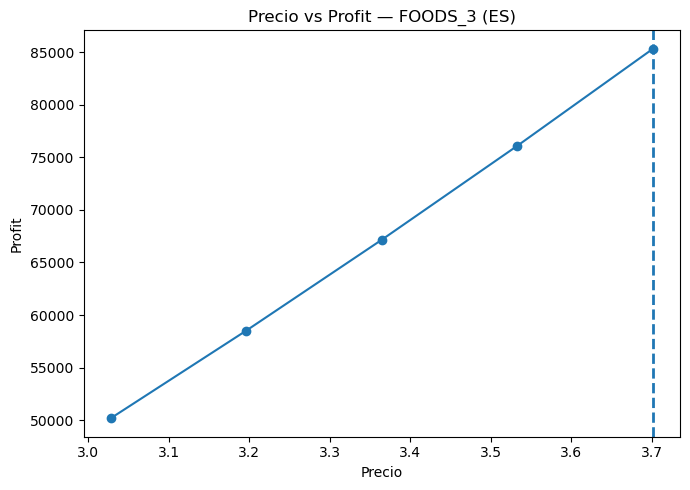

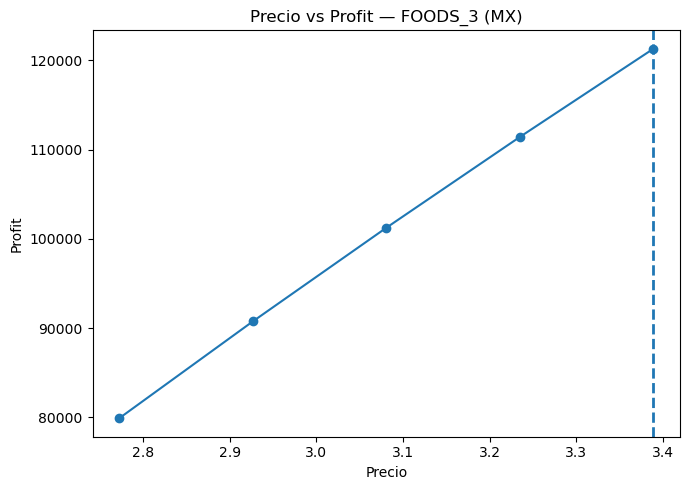

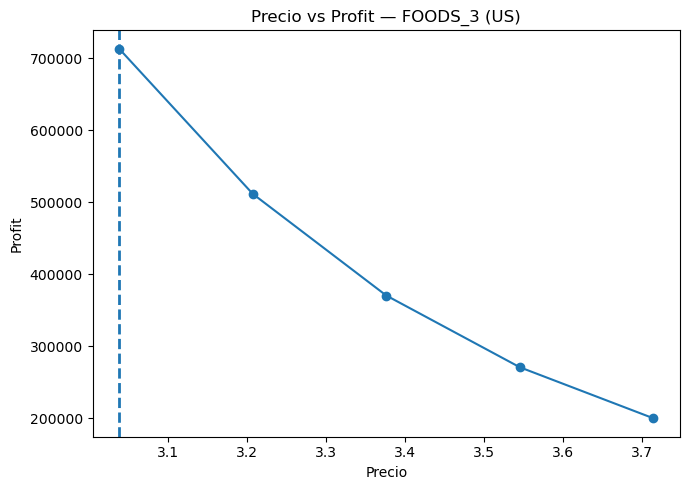

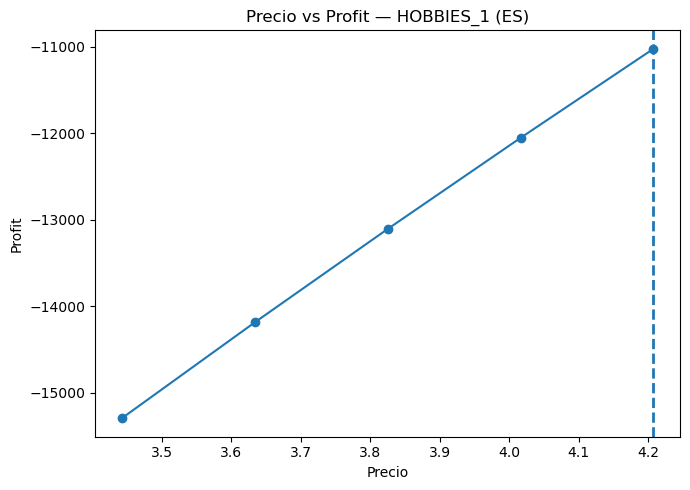

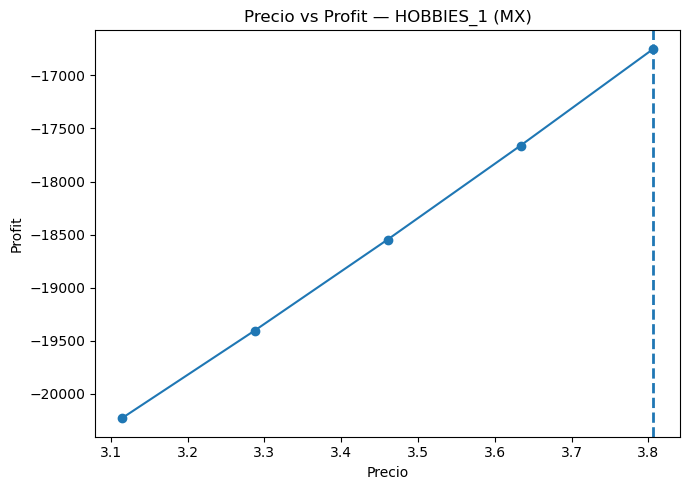

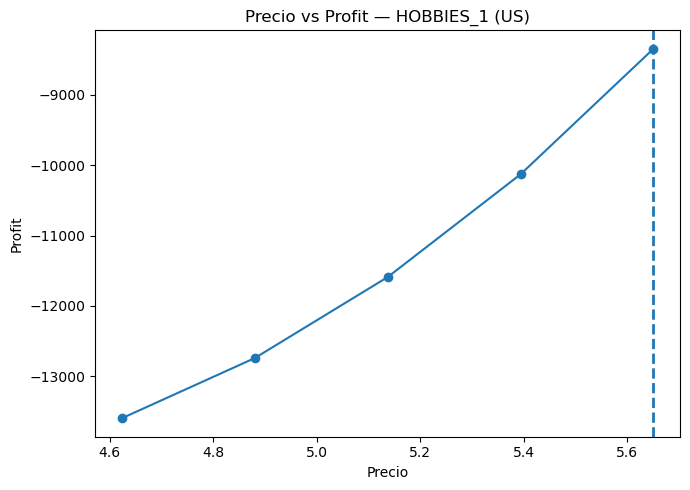

In [33]:
for _, row in optimal_pricing.iterrows():
    plot_price_profit(
        sim_df,
        optimal_pricing,
        row['dept_id'],
        row['country']
    )


In [34]:
#Tabla ejecutiva

exec_summary = optimal_pricing.merge(
    baseline[['dept_id','country','avg_price','units','revenue','profit','elasticity','unit_cost']],
    on=['dept_id','country'],
    suffixes=('_opt','_base')
)

# Renombrar columnas para claridad
exec_summary = exec_summary.rename(columns={
    'avg_price': 'price_base',
    'units_base': 'units_base',
    'revenue_base': 'revenue_base',
    'profit_base': 'profit_base'
})


In [35]:
exec_summary.columns

Index(['dept_id', 'country', 'price_change_pct', 'new_price', 'units_opt',
       'revenue_opt', 'profit_opt', 'profit_baseline', 'profit_delta',
       'price_base', 'units_base', 'revenue_base', 'profit_base', 'elasticity',
       'unit_cost'],
      dtype='object')

In [36]:
import numpy as np
import pandas as pd

# 1) Baseline "limpio"
baseline_clean = baseline.rename(columns={
    'avg_price': 'price_base',
    'units': 'units_base',
    'revenue': 'revenue_base',
    'profit': 'profit_base'
}).copy()

# 2) Optimal "limpio" (desde sim_df -> optimal_pricing ya trae units/revenue/profit del escenario)
optimal_clean = optimal_pricing.rename(columns={
    'new_price': 'price_opt',
    'units': 'units_opt',
    'revenue': 'revenue_opt',
    'profit': 'profit_opt'
}).copy()

# 3) Merge 1: baseline + optimal
exec_summary = optimal_clean.merge(
    baseline_clean[['dept_id','country','price_base','units_base','revenue_base','profit_base','unit_cost','elasticity']],
    on=['dept_id','country'],
    how='left'
)

# 4) Si optimal_pricing ya trae profit_baseline/profit_delta, los usamos como verdad del sim
# (Opcional) fuerza consistencia:
if 'profit_baseline' in exec_summary.columns:
    exec_summary['profit_base'] = exec_summary['profit_baseline']
if 'profit_delta' not in exec_summary.columns:
    exec_summary['profit_delta'] = exec_summary['profit_opt'] - exec_summary['profit_base']

# 5) Cambios relativos (%)
exec_summary['price_delta_pct'] = exec_summary['price_opt'] / exec_summary['price_base'] - 1
exec_summary['units_delta_pct'] = exec_summary['units_opt'] / exec_summary['units_base'] - 1
exec_summary['revenue_delta_pct'] = exec_summary['revenue_opt'] / exec_summary['revenue_base'] - 1

# cuidado con profit_base negativo o 0 (en HOBBIES)
exec_summary['profit_delta_pct'] = exec_summary['profit_delta'] / exec_summary['profit_base'].replace(0, np.nan)


In [37]:
def recommendation(row):
    pc = row.get('price_change_pct', None)
    if pc is None:
        pc = row['price_delta_pct']
    base_profit = row['profit_base']
    opt_profit = row['profit_opt']
    
    if opt_profit < 0 and base_profit < 0:
        return "Subir precio ayuda, pero sigue en pérdida; revisar costos/mix"
    if pc > 0:
        return "Subir precio para capturar margen"
    if pc < 0:
        return "Bajar precio para impulsar volumen"
    return "Mantener precio (sin mejora clara)"

exec_summary['recommendation'] = exec_summary.apply(recommendation, axis=1)


In [39]:
#Executive Summary final...

final_table = exec_summary[[
    'dept_id','country',
    'elasticity','unit_cost',
    'price_base','price_opt','price_change_pct',
    'units_base','units_opt','units_delta_pct',
    'revenue_base','revenue_opt','revenue_delta_pct',
    'profit_base','profit_opt','profit_delta','profit_delta_pct',
    'recommendation'
]].copy()

# formato
final_table['elasticity'] = final_table['elasticity'].round(2)
final_table['unit_cost'] = final_table['unit_cost'].round(2)

for col in ['price_base','price_opt']:
    final_table[col] = final_table[col].round(3)

for col in ['units_base','units_opt','revenue_base','revenue_opt','profit_base','profit_opt','profit_delta']:
    final_table[col] = final_table[col].round(2)

for col in ['price_change_pct','units_delta_pct','revenue_delta_pct','profit_delta_pct']:
    final_table[col] = (final_table[col] * 100).round(2)

final_table = final_table.sort_values(['dept_id','country'])
final_table


,dept_id,country,elasticity,unit_cost,price_base,price_opt,price_change_pct,units_base,units_opt,units_delta_pct,revenue_base,revenue_opt,revenue_delta_pct,profit_base,profit_opt,profit_delta,profit_delta_pct,recommendation
0,FOODS_3,ES,0.47,1.8,3.365,3.701,10.0,42925,44871.55,4.53,143766.34,166073.19,15.52,66501.34,85304.41,18803.07,28.27,Subir precio para capturar margen
1,FOODS_3,MX,-0.37,1.8,3.081,3.389,10.0,79052,76345.40,-3.42,241894.88,258705.38,6.95,99601.28,121283.65,21682.37,21.77,Subir precio para capturar margen
2,FOODS_3,US,-8.50,1.8,3.377,3.039,-10.0,234969,575495.09,144.92,789041.03,1748893.56,121.65,366096.83,713002.40,346905.57,94.76,Bajar precio para impulsar volumen
3,HOBBIES_1,ES,-0.19,6.5,3.825,4.208,10.0,4900,4809.78,-1.84,18746.65,20238.11,7.96,-13103.35,-11025.49,2077.86,-15.86,"Subir precio ayuda, pero sigue en pérdida; rev..."
4,HOBBIES_1,MX,0.20,6.5,3.461,3.807,10.0,6102,6218.38,1.91,21127.45,23670.62,12.04,-18535.55,-16748.82,1786.73,-9.64,"Subir precio ayuda, pero sigue en pérdida; rev..."
5,HOBBIES_1,US,1.52,6.5,5.137,5.651,10.0,8506,9834.29,15.62,43818.81,55574.39,26.83,-11470.19,-8348.52,3121.67,-27.22,"Subir precio ayuda, pero sigue en pérdida; rev..."
